<a href="https://colab.research.google.com/github/christinawanggg/ait-dl-deepfake/blob/main/AIT_DL_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# AIT - Deep Learning Fall 2021
# Final Project
# Scaffolding and assignment completed by Christina Wang and Isabel Grondin

In [1]:
# Loading Libraries
import numpy as np 
import pandas as pd 
import zipfile
from math import sqrt
import matplotlib.pyplot as plt
import scipy.stats
import seaborn as sns
import os
import tensorflow as tf
from keras.preprocessing import image
from keras.utils import np_utils
from skimage.transform import resize
from PIL import Image

from tensorflow import keras
model = tf.keras.models.Sequential()


# Data Set

*   Celeb Deepfake 1: https://drive.google.com/file/d10NGF38RgF8FZneKOuCOdRIsPzpC7_WDd/view


The Celeb Deepfake 1 dataset includes a combination of 1203 real and fake/synthesized videos of celebrities from Youtube. The current state of our project is utilizing this data set.

## Data Extraction

First, we needed to extract all of the videos in the the data from a zip file.



In [ ]:
# Imports needed for data extraction
from google.colab import drive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
import zipfile


In [3]:
# using Pydrive to connect to Google Drive
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()

drive = GoogleDrive(gauth)

In [4]:
file_id = "10NGF38RgF8FZneKOuCOdRIsPzpC7_WDd"
file_list = drive.ListFile({'q': "'%s' in parents and trashed=false" % file_id}).GetList()

In [5]:
downloaded = drive.CreateFile({'id': "10NGF38RgF8FZneKOuCOdRIsPzpC7_WDd"})
downloaded.GetContentFile('Celeb-DF.zip')

In [6]:
# extracting all the videos from the zip file

zip = zipfile.ZipFile("Celeb-DF.zip")
zip.extractall()
videoNameList = zip.namelist()

# Data Pre-Processing

First, we parsed the videos into individual jpg frames. We then resized and cropped the images to all share the same dimensions for later usage. Finally, we extracted the images into a pixel array format and flattened the shape of all the images. 

In [92]:
# Imports needed for standardizing data set
import cv2
import math
from PIL import Image

In [7]:
# Cleaning up the data set

videoNameList.remove("Celeb-real/")
videoNameList.remove("Celeb-synthesis/")
videoNameList.remove("YouTube-real/")
videoNameList.remove("List_of_testing_videos.txt")

print(videoNameList)

['Celeb-real/id0_0000.mp4', 'Celeb-real/id0_0001.mp4', 'Celeb-real/id0_0002.mp4', 'Celeb-real/id0_0003.mp4', 'Celeb-real/id0_0004.mp4', 'Celeb-real/id0_0005.mp4', 'Celeb-real/id0_0006.mp4', 'Celeb-real/id0_0007.mp4', 'Celeb-real/id0_0008.mp4', 'Celeb-real/id0_0009.mp4', 'Celeb-real/id10_0000.mp4', 'Celeb-real/id10_0001.mp4', 'Celeb-real/id10_0002.mp4', 'Celeb-real/id10_0003.mp4', 'Celeb-real/id10_0004.mp4', 'Celeb-real/id10_0005.mp4', 'Celeb-real/id10_0006.mp4', 'Celeb-real/id10_0007.mp4', 'Celeb-real/id10_0008.mp4', 'Celeb-real/id10_0009.mp4', 'Celeb-real/id11_0000.mp4', 'Celeb-real/id11_0001.mp4', 'Celeb-real/id11_0002.mp4', 'Celeb-real/id11_0003.mp4', 'Celeb-real/id11_0004.mp4', 'Celeb-real/id11_0005.mp4', 'Celeb-real/id11_0006.mp4', 'Celeb-real/id11_0007.mp4', 'Celeb-real/id11_0008.mp4', 'Celeb-real/id11_0009.mp4', 'Celeb-real/id11_0010.mp4', 'Celeb-real/id12_0000.mp4', 'Celeb-real/id12_0001.mp4', 'Celeb-real/id12_0002.mp4', 'Celeb-real/id12_0003.mp4', 'Celeb-real/id12_0004.mp4', '

In [8]:
# Extracting an individual frame or jpg image from each video

videos_dict = {} # used to see both the video name and resulting filename
videos_frames = []
videos_listY = [] # serving as our 'Y'

for i in range(len(videoNameList)):
  videoFile = "/content/" + videoNameList[i]
  cap = cv2.VideoCapture(videoFile)   # capturing the video from the given path
  frameRate = cap.get(5) # frame rate
  x=1
  frameId = cap.get(1) # current frame number
  ret, frame = cap.read()
  if (frameId % math.floor(frameRate) == 0):
      filename ="frame%d.jpg" % count;count+=1
      cv2.imwrite(filename, frame)
      videos_dict[videoNameList[i]] = filename
      videos_frames.append(filename) 
  if 'real' in videoNameList[i]:
    videos_listY.append(1)
  elif 'synthesis' in videoNameList[i]:
    videos_listY.append(0)
cap.release()

print(videos_dict)
print(videos_frames)
print(videos_listY)

{'Celeb-real/id0_0000.mp4': 'frame0.jpg', 'Celeb-real/id0_0001.mp4': 'frame1.jpg', 'Celeb-real/id0_0002.mp4': 'frame2.jpg', 'Celeb-real/id0_0003.mp4': 'frame3.jpg', 'Celeb-real/id0_0004.mp4': 'frame4.jpg', 'Celeb-real/id0_0005.mp4': 'frame5.jpg', 'Celeb-real/id0_0006.mp4': 'frame6.jpg', 'Celeb-real/id0_0007.mp4': 'frame7.jpg', 'Celeb-real/id0_0008.mp4': 'frame8.jpg', 'Celeb-real/id0_0009.mp4': 'frame9.jpg', 'Celeb-real/id10_0000.mp4': 'frame10.jpg', 'Celeb-real/id10_0001.mp4': 'frame11.jpg', 'Celeb-real/id10_0002.mp4': 'frame12.jpg', 'Celeb-real/id10_0003.mp4': 'frame13.jpg', 'Celeb-real/id10_0004.mp4': 'frame14.jpg', 'Celeb-real/id10_0005.mp4': 'frame15.jpg', 'Celeb-real/id10_0006.mp4': 'frame16.jpg', 'Celeb-real/id10_0007.mp4': 'frame17.jpg', 'Celeb-real/id10_0008.mp4': 'frame18.jpg', 'Celeb-real/id10_0009.mp4': 'frame19.jpg', 'Celeb-real/id11_0000.mp4': 'frame20.jpg', 'Celeb-real/id11_0001.mp4': 'frame21.jpg', 'Celeb-real/id11_0002.mp4': 'frame22.jpg', 'Celeb-real/id11_0003.mp4': 'f

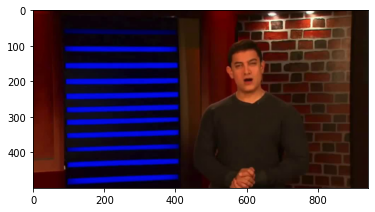

In [11]:
# Displaying a real image

img = plt.imread('frame0.jpg')
plt.imshow(img)


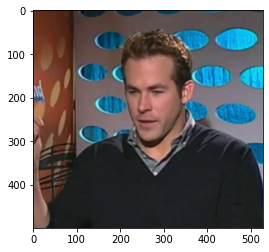

In [12]:
# Displaying a fake image

img2 = plt.imread('frame628.jpg')
plt.imshow(img2)


In [13]:
# comparing the attributes of the real vs fake image
print("Mode - Img-real: ", imgpil.mode, " Img-fake: ", img2pil.mode)
print("Size - Img-real: ", imgpil.size, " Img-fake: ", img2pil.size)
print("Palette - Img-real: ", imgpil.palette, " Img-fake: ", img2pil.palette)


Mode - Img-real:  RGB  Img-fake:  RGB
Size - Img-real:  (942, 500)  Img-fake:  (528, 500)
Palette - Img-real:  None  Img-fake:  None


In [14]:
# Standardizing the mode of the images

sizes = {}
for i in range(len(videos_frames)):
  curr_image = Image.open(videos_frames[i])
  
  if curr_image.mode != 'RGB':
    png = curr_image.convert('RGBA')
    background = Image.new('RGBA', png.size, (255,255,255))

    alpha_composite = Image.alpha_composite(background, png)



  sizes[videos_frames[i]] = curr_image.size

print(sizes)
print(len(sizes))
  

{'frame0.jpg': (942, 500), 'frame1.jpg': (942, 500), 'frame2.jpg': (942, 500), 'frame3.jpg': (942, 500), 'frame4.jpg': (942, 500), 'frame5.jpg': (942, 500), 'frame6.jpg': (942, 500), 'frame7.jpg': (942, 500), 'frame8.jpg': (942, 500), 'frame9.jpg': (942, 500), 'frame10.jpg': (658, 500), 'frame11.jpg': (948, 500), 'frame12.jpg': (956, 500), 'frame13.jpg': (956, 500), 'frame14.jpg': (962, 500), 'frame15.jpg': (956, 500), 'frame16.jpg': (612, 500), 'frame17.jpg': (956, 500), 'frame18.jpg': (544, 500), 'frame19.jpg': (960, 500), 'frame20.jpg': (450, 500), 'frame21.jpg': (938, 500), 'frame22.jpg': (966, 500), 'frame23.jpg': (950, 500), 'frame24.jpg': (950, 500), 'frame25.jpg': (950, 500), 'frame26.jpg': (950, 500), 'frame27.jpg': (950, 500), 'frame28.jpg': (950, 500), 'frame29.jpg': (950, 500), 'frame30.jpg': (776, 500), 'frame31.jpg': (962, 500), 'frame32.jpg': (950, 500), 'frame33.jpg': (922, 500), 'frame34.jpg': (922, 500), 'frame35.jpg': (922, 500), 'frame36.jpg': (952, 500), 'frame37.j

354
frame72.jpg


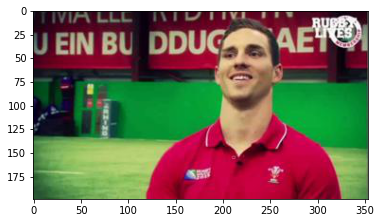

In [93]:
# Extracting the minimum size to know what to use for as
# a resize parameter using the thumbnail method of image resizing

min = 100000
minkey = 0

for key,value in sizes.items():
  if sizes[key][0] < min:
    min = sizes[key][0]
    minkey = key

print(min)
print(minkey)
img2 = plt.imread(key)
plt.imshow(img2)

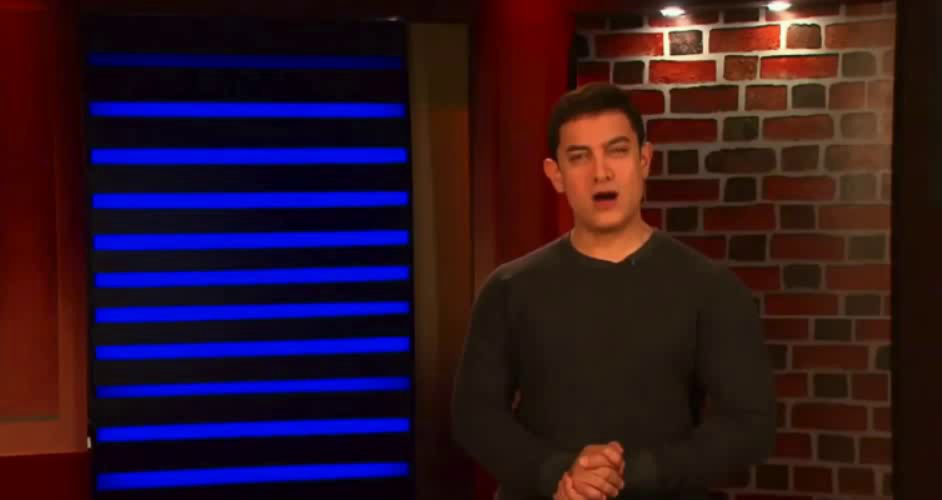

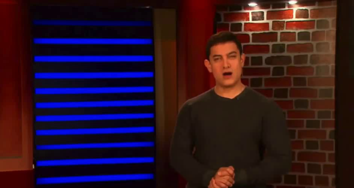

(354, 188)


In [16]:
# resizing a test image (frame0.jpg) 

im0 = Image.open("frame0.jpg")

display(im0)
im0.thumbnail((354,500))
display(im0)

print(im0.size)

In [17]:
# Resizing all of the images using the thumbnail method

for key,value in videos_dict.items():
  im0 = Image.open(videos_dict[key])

  im0.thumbnail((354,500))
  im0.save(videos_dict[key])
  

In [94]:
# Storing the dimensions of all of the data in img_shapes for later usage

img_shapes = []

for key,value in videos_dict.items():
  newim = Image.open(videos_dict[key])
  data = asarray(newim)
  img_shapes.append(data.shape)


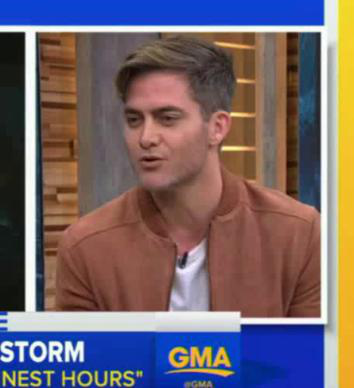

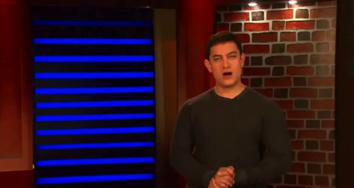

In [23]:
# As you can see, even though we reshaped using the thumbnail method,
# some images, still don't have the same dimensions

img = Image.open('frame315.jpg')
display(img)

img2 = Image.open('frame0.jpg')
display(img2)

In [95]:
# Since not all of the shapes of the images match, we want to crop the larger
# photos at the center, scaling them all down to the same shape
# We chose not to use the resize method to keep the proportions the same

videos_datalist = []

for key,value in videos_dict.items():
  im = Image.open(videos_dict[key])
  width, height = im.size   # Get dimensions

  left = (width - 354)/2
  top = (height - 188)/2
  right = (width + 354)/2
  bottom = (height + 188)/2

  # Crop the center of the image
  im = im.crop((left, top, right, bottom))
  data = asarray(im)
  videos_datalist.append(data)

In [60]:
# Reshaping all images to be (188*354*3,)

for i in range(len(videos_datalist)):
  data = videos_datalist[i].reshape(354*188*3,)

  videos_datalist[i] = data
  
  print(i, ": ", data)



0 :  [94  0  0 ... 31 10  5]
1 :  [0 0 0 ... 0 0 0]
2 :  [92 72 65 ... 74 76 73]
3 :  [0 0 0 ... 0 0 0]
4 :  [0 0 0 ... 0 0 0]
5 :  [0 0 0 ... 0 0 0]
6 :  [148  89  59 ... 254 247 203]
7 :  [  0   2   0 ... 126 110 110]
8 :  [17 18 13 ... 43 22 19]
9 :  [110  85  78 ...  98  49  52]
10 :  [ 5  7 28 ... 75 69 83]
11 :  [2 0 3 ... 0 0 0]
12 :  [0 0 0 ... 0 0 0]
13 :  [0 0 0 ... 0 0 0]
14 :  [0 0 0 ... 0 0 0]
15 :  [0 0 0 ... 0 0 0]
16 :  [39 28 22 ... 32 27 24]
17 :  [0 0 0 ... 0 0 0]
18 :  [116  85  80 ... 133 114  97]
19 :  [0 0 0 ... 0 0 0]
20 :  [106  49  30 ...  72  73  78]
21 :  [ 4 12  1 ...  9 14  8]
22 :  [0 0 0 ... 0 0 0]
23 :  [0 0 0 ... 0 0 0]
24 :  [0 0 0 ... 0 0 0]
25 :  [0 0 0 ... 0 0 0]
26 :  [0 0 0 ... 0 0 0]
27 :  [0 0 0 ... 0 0 0]
28 :  [0 0 0 ... 0 0 0]
29 :  [0 0 0 ... 0 0 0]
30 :  [149 125 101 ... 212 216 227]
31 :  [0 0 0 ... 0 0 0]
32 :  [0 0 0 ... 0 0 0]
33 :  [248 250 245 ... 251 253 252]
34 :  [176 158 156 ... 210 188 165]
35 :  [ 60  65  84 ...  88  97 140]
36

### Splitting The Data

Splitting the data into train and test sets.


In [ ]:
# Imports needed to split the data
from sklearn.model_selection import train_test_split

In [79]:
# do a train-test split
X_train, X_test, Y_train, Y_test = train_test_split(videos_datalist, videos_listY, test_size=0.4, random_state=2)

In [83]:
# converting lists to numpy arrays

X_train = asarray(X_train)
X_test = asarray(X_test)
Y_train = asarray(Y_train)
Y_test = asarray(Y_test)

In [70]:
# convert to float after resizing images

X_train = X_train.astype("float32") / 255
X_test  = X_test.astype("float32") / 255